<a href="https://colab.research.google.com/github/Calobite/ml-model-development/blob/main/ingrediendt_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4305, done.
remote: Counting objects: 100% (4305/4305), done.
remote: Compressing objects: 100% (3321/3321), done.
remote: Total 4305 (delta 1208), reused 2225 (delta 911), pack-reused 0 (from 0)
Receiving objects: 100% (4305/4305), 53.16 MiB | 25.90 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.


In [2]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7

In [3]:
!pip install protobuf==3.20 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.60.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<4.26.0,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.19.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-aiplatform 1.71.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery-connection 1.16.1 requires protobuf!=

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
# import object detection api
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import colab_utils

# Utilitites

In [153]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=20,
        min_score_thresh=0.3)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)


# Load dataset

In [7]:
!pip install roboflow -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.


In [8]:
from roboflow import Roboflow
!rm -rf dataset

rf = Roboflow(api_key="lQr15x1tN1apGpIqEmra")
project = rf.workspace("food-recipe-ingredient-images-0gnku").project("food-ingredients-dataset")
version = project.version(4)
dataset = version.download("tensorflow",location='dataset')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dataset in tensorflow:: 100%|██████████| 9742/9742 [00:03<00:00, 3099.67it/s]


In [9]:
TRAIN_ANNOTATION_PATH = './dataset/train/_annotations.csv'
TRAIN_PATH = './dataset/train'
TEST_PATH = './dataset/test'
TEST_ANNOTATION_PATH = './dataset/test/_annotations.csv'
VALID_PATH = './dataset/valid'
VALID_ANNOTATION_PATH = './dataset/valid/_annotations.csv'

In [10]:
import pandas as pd

df = pd.read_csv(TRAIN_ANNOTATION_PATH)
df.describe()

width   height          xmin          ymin          xmax  \
count  19488.0  19488.0  19488.000000  19488.000000  19488.000000   
mean     640.0    640.0    185.897116    173.312757    455.552853   
std        0.0      0.0    143.724299    134.729093    144.650546   
min      640.0    640.0      0.000000      0.000000     36.000000   
25%      640.0    640.0     60.000000     60.000000    342.000000   
50%      640.0    640.0    157.000000    145.000000    485.000000   
75%      640.0    640.0    297.000000    271.000000    581.000000   
max      640.0    640.0    604.000000    626.000000    640.000000   

               ymax  
count  19488.000000  
mean     466.941297  
std      136.559163  
min       14.000000  
25%      366.000000  
50%      498.000000  
75%      583.000000  
max      640.000000

In [11]:
# prompt: add filter where height is equal to 196 and class is Beans

df.head()

filename  width  height  \
0  download-1-_jpg.rf.00018808842c2f521772e83f35a...    640     640   
1  download_jpg.rf.0008224bb54982df22e1468a118651...    640     640   
2  download_jpg.rf.0008224bb54982df22e1468a118651...    640     640   
3  download_jpg.rf.0008224bb54982df22e1468a118651...    640     640   
4  364358893_990569905513546_1245418979220757951_...    640     640   

                     class  xmin  ymin  xmax  ymax  
0            Bethu ko Saag    61   114   561   548  
1             Bitter Gourd   183    66   640   307  
2             Bitter Gourd     1   197   491   563  
3             Bitter Gourd   113   105   533   554  
4  Chili Pepper -Khursani-   213    90   549   481

In [12]:
len(df)

19488

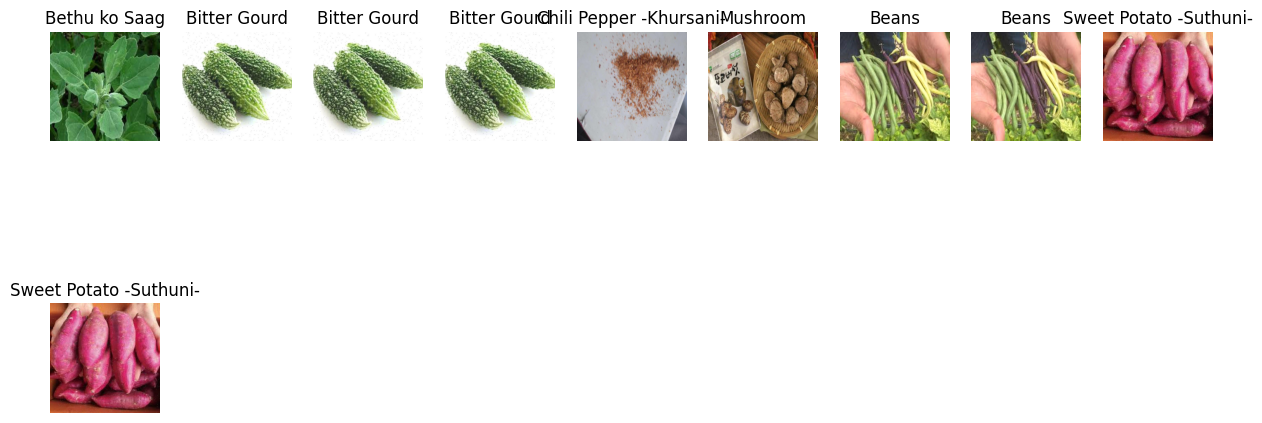

In [13]:
# Visualize train image
%matplotlib inline
fig = plt.figure(figsize=(15,10))
end_idx = 10

temp_images_np = []
for i in range(end_idx):
    image_path = os.path.join(TRAIN_PATH, df.iloc[i]['filename'])
    temp_images_np.append(load_image_into_numpy_array(image_path))

for idx, image_np in enumerate(temp_images_np):
    ax = fig.add_subplot(3, end_idx - 1, idx+1)
    ax.imshow(image_np)
    ax.set_title(df.iloc[idx]['class'])
    ax.axis('off')

# Preprocessing

In [42]:
def create_category_index(csv_file, filter_class= None):
  df = pd.read_csv(csv_file)
  if filter_class is not None:
    df = df[df['class'] == filter_class]
  class_name = df['class'].unique()
  category_index = {}
  for i, name in enumerate(class_name):
    category_index[i+1] = {'id': i+1, 'name': name}
  return category_index

def parse_annotations(csv_file, images_dir, category_index, filter_class = None):
    name_to_id = {item['name']: item['id'] for item in category_index.values()}
    df = pd.read_csv(csv_file)
    if filter_class is not None:
      df = df[df['class'] == filter_class]

    data = []
    for _, row in df.iterrows():
        if row['class'] not in name_to_id:
          continue
        image_path = os.path.join(images_dir, row['filename'])
        # Normalize bounding boxes to [0, 1]
        gt_boxes = np.array([
            [
             row['ymin'] / row['height'],
             row['xmin'] / row['width'],
             row['ymax'] / row['height'],
             row['xmax'] / row['width']
            ]
        ], dtype=np.float32)
        class_id = name_to_id[row['class']]
        data.append((image_path, gt_boxes, class_id))
    return data

def create_tf_dataset(data, category_index):

  dataset = tf.data.Dataset.from_generator(
      lambda: iter(data),
      output_types=(tf.string, tf.float32, tf.float32),
  )

  def preprocess(image_path, gt_boxes, class_id):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)
    gt_boxes = tf.convert_to_tensor(gt_boxes, dtype=tf.float32)

    # class_id = tf.convert_to_tensor(class_id, dtype=tf.int32)
    adjusted_class_id = class_id - 1

    gt_classes = tf.one_hot([adjusted_class_id], depth=len(category_index), dtype=tf.float32)
    return image, gt_boxes, gt_classes

  dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
  return dataset




In [95]:
#  processing dataset
print("[INFO] Processing dataset")

category_index = create_category_index(TRAIN_ANNOTATION_PATH, "Ham")
train_data = parse_annotations(TRAIN_ANNOTATION_PATH, TRAIN_PATH, category_index, "Ham")
test_data = parse_annotations(TEST_ANNOTATION_PATH, TEST_PATH, category_index, "Ham")
valid_data = parse_annotations(VALID_ANNOTATION_PATH, VALID_PATH, category_index, "Ham")

train_dataset = create_tf_dataset(train_data, category_index)
test_dataset = create_tf_dataset(test_data, category_index)
valid_dataset = create_tf_dataset(valid_data, category_index)
num_classes = len(category_index)


print("[INFO] Done")





[INFO] Processing dataset
[INFO] Done


In [90]:
len(train_data)

90

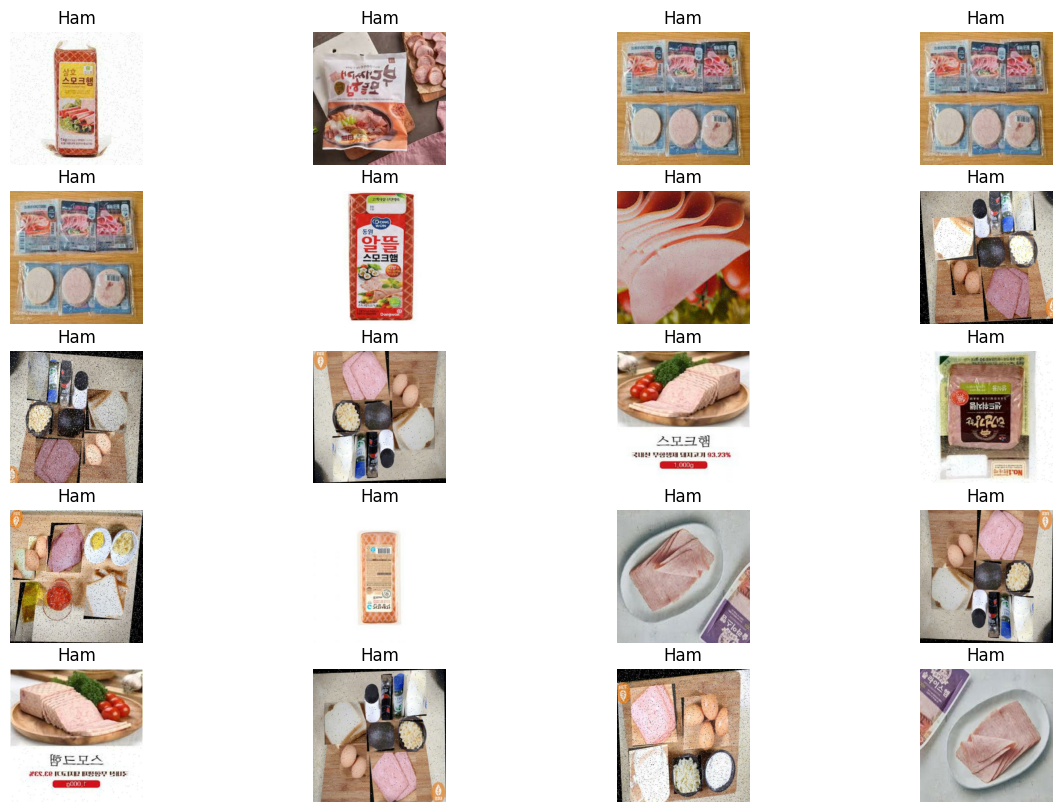

In [56]:
fig = plt.figure(figsize=(15,10))
end_idx = 20
for idx, (images, gt_boxes, gt_classes) in enumerate(train_dataset.take(end_idx)):
    # get one index that not zero from gt_classess
    index = np.argmax(gt_classes.numpy()) + 1

    ax = fig.add_subplot(5, 4, idx+1)
    ax.imshow(images.numpy()[0].astype(np.uint32))
    ax.set_title(category_index[index].get('name'))
    ax.axis('off')

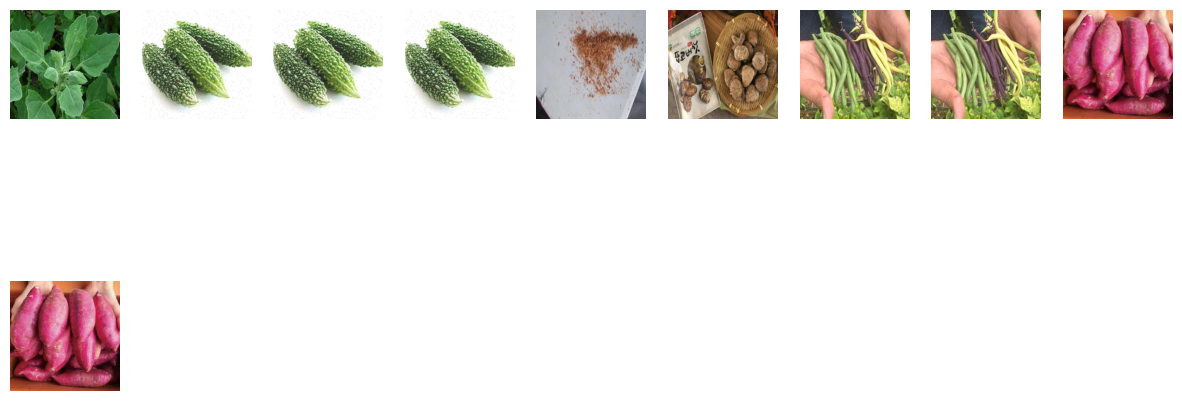

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

# Visualize train images with bounding boxes
fig = plt.figure(figsize=(15, 10))
end_idx = 10

temp_images_np = []
temp_gt_boxes = []  # Store ground truth boxes
temp_classes = []  # Store class labels

# Load images and annotations
for i in range(end_idx):
    image_path = os.path.join(TRAIN_PATH, df.iloc[i]['filename'])
    temp_images_np.append(load_image_into_numpy_array(image_path))
    # Assuming you have the ground truth boxes in your dataframe
    gt_box = np.array([[
        df.iloc[i]['ymin'],
        df.iloc[i]['xmin'],
        df.iloc[i]['ymax'],
        df.iloc[i]['xmax'],
    ]], dtype=np.float32)
    temp_gt_boxes.append(gt_box)
    temp_classes.append(df.iloc[i]['class'])

# Plot images with bounding boxes using plot_detections
for idx, image_np in enumerate(temp_images_np):
    ax = fig.add_subplot(3, end_idx - 1, idx + 1)
    # Plot using your predefined plot_detections function
    plot_detections(
        image_np,
        temp_gt_boxes[idx],  # Pass ground truth boxes
        [category_index.get(cls, {}).get('id', 0) for cls in [temp_classes[idx]]],  # Get the class IDs from category_index
        None,  # Since we don't have scores, we pass None
        category_index
    )
    ax.axis('off')

plt.show()


In [58]:
for images, gt_boxes, gt_classes in train_dataset.take(1):
    print(images)
    print(gt_boxes)
    print(gt_classes)

tf.Tensor(
[[[[252. 252. 252.]
   [252. 252. 252.]
   [252. 252. 252.]
   ...
   [253. 253. 253.]
   [253. 253. 253.]
   [253. 253. 253.]]

  [[252. 252. 252.]
   [252. 252. 252.]
   [252. 252. 252.]
   ...
   [253. 253. 253.]
   [253. 253. 253.]
   [253. 253. 253.]]

  [[252. 252. 252.]
   [252. 252. 252.]
   [252. 252. 252.]
   ...
   [253. 253. 253.]
   [253. 253. 253.]
   [253. 253. 253.]]

  ...

  [[253. 253. 253.]
   [253. 253. 253.]
   [253. 253. 253.]
   ...
   [240. 240. 240.]
   [255. 255. 255.]
   [253. 253. 253.]]

  [[253. 253. 253.]
   [253. 253. 253.]
   [253. 253. 253.]
   ...
   [248. 248. 248.]
   [255. 255. 255.]
   [247. 247. 247.]]

  [[253. 253. 253.]
   [253. 253. 253.]
   [253. 253. 253.]
   ...
   [255. 255. 255.]
   [253. 253. 253.]
   [254. 254. 254.]]]], shape=(1, 640, 640, 3), dtype=float32)
tf.Tensor([[0.0375    0.2796875 0.98125   0.7828125]], shape=(1, 4), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


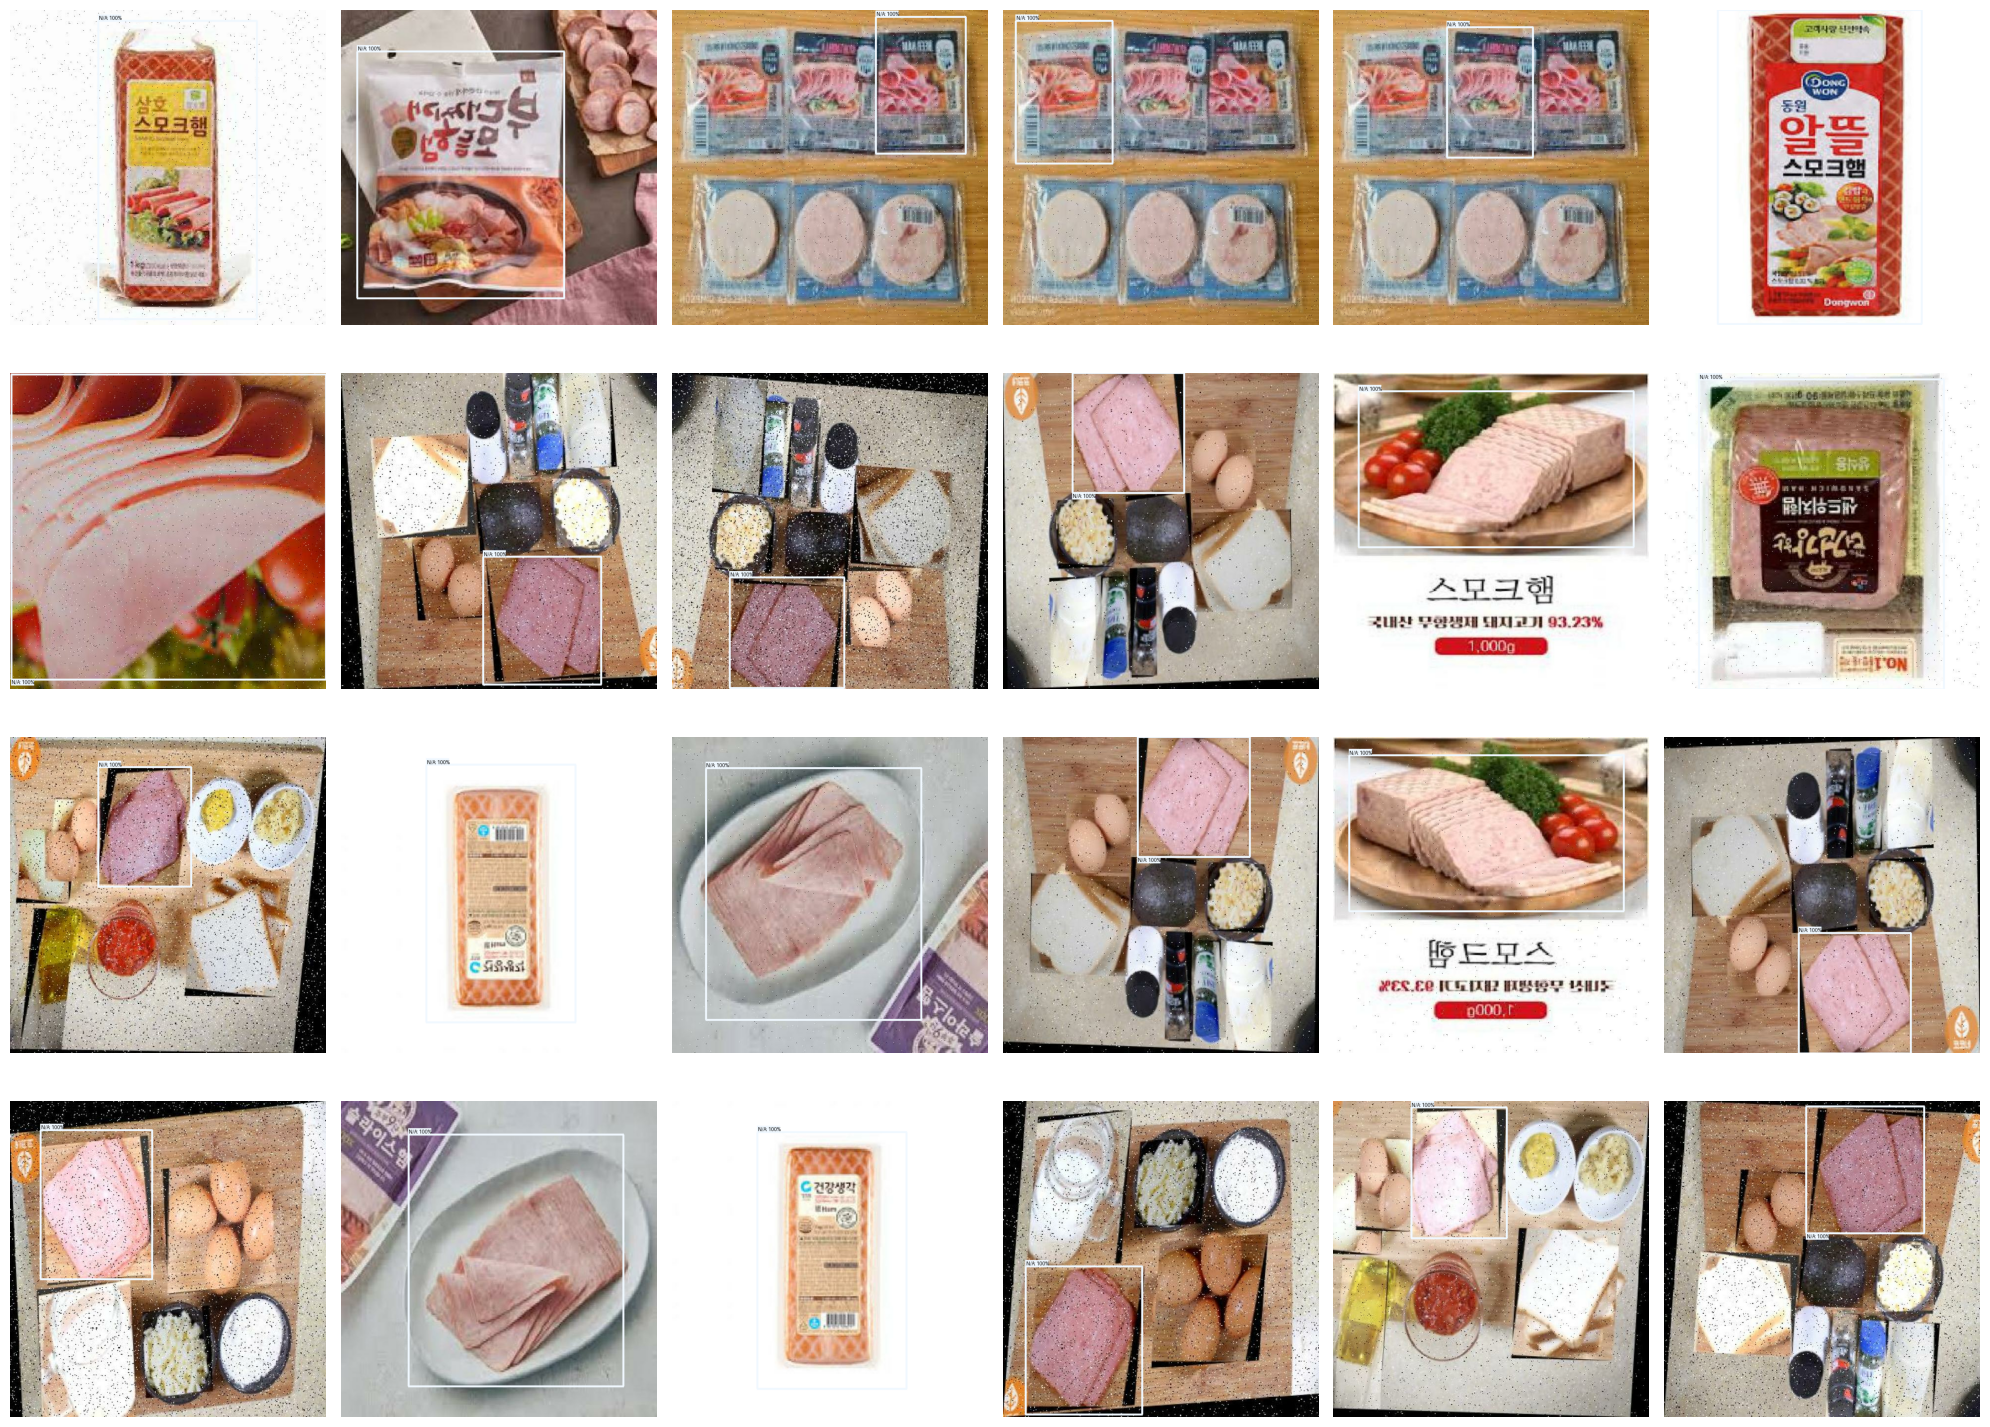

In [59]:
# inspect
dummy_scores = np.array([1, 0], dtype=np.float32)

plt.figure(figsize=(20, 15))
for i, (images, gt_boxes, gt_classes) in enumerate(train_dataset.take(24)):
    plt.subplot(4, 6, i + 1)

    image = images.numpy().squeeze()
    gt_boxes = gt_boxes.numpy()
    gt_classes = gt_classes.numpy()
    gt_class_ids = np.argmax(gt_classes)

    # Call your custom plotting function
    plot_detections(
        image.astype(np.uint32),
        gt_boxes,
        [gt_class_ids],
        dummy_scores,
        category_index,
        figsize=(30,30),
    )

    plt.axis("off")  # Hide axis for a cleaner visualization

plt.tight_layout()
plt.show()

# Download checkpoints

In [126]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
!rm -rf models/research/object_detection/test_data/checkpoint
!rm -rf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-11-23 19:36:21--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.79.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  40.4MB/s    in 6.6s    

2024-11-23 19:36:28 (35.1 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



# Configure the model

In [127]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

Building model and restoring weights for fine-tuning...


In [128]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


# Eager mode custom training loop

In [129]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [130]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)

      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

In [131]:
gt_box_tensors = []
gt_classes_one_hot_tensors = []
train_image_tensors = []

for image_np, gt_box, gt_class in train_dataset:
  train_image_tensors.append(image_np.numpy())
  gt_box_tensors.append(gt_box)
  gt_classes_one_hot_tensors.append(gt_class)


In [132]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(100):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_data)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(100)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.2041224
batch 10 of 100, loss=2.9129953
batch 20 of 100, loss=1.169986
batch 30 of 100, loss=0.97320753
batch 40 of 100, loss=0.8966061
batch 50 of 100, loss=0.6175483
batch 60 of 100, loss=0.6939071
batch 70 of 100, loss=0.2119435
batch 80 of 100, loss=0.42232123
batch 90 of 100, loss=0.4043424
Done fine-tuning!


In [108]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(images, groundtruth_boxes, groundtruth_classes):
        """
        A single training iteration.

        Args:
            images: A [batch_size, height, width, 3] Tensor of type tf.float32.
              Note that the height and width may vary but will be reshaped to 640x640.
            groundtruth_boxes: A [batch_size, N, 4] Tensor of type tf.float32
              representing groundtruth boxes for each image in the batch.
            groundtruth_classes: A [batch_size, N, num_classes] Tensor of type
              tf.float32 representing groundtruth classes for each image in the batch.

        Returns:
            A scalar tensor representing the total loss for the input batch.
        """

        # Define the target input shape for resizing
        target_shape = (640, 640)
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)

        # Provide ground truth to the model
        model.provide_groundtruth(
            groundtruth_boxes_list=tf.unstack(groundtruth_boxes),
            groundtruth_classes_list=tf.unstack(groundtruth_classes)
        )

        with tf.GradientTape() as tape:
            # Preprocess all images in the batch
            preprocessed_images = tf.concat(
                [model.preprocess(tf.image.resize(image, target_shape))[0] for image in tf.unstack(images)],
                axis=0
            )

            # Predict and compute the loss
            prediction_dict = model.predict(preprocessed_images, shapes)
            loss_dict = model.loss(prediction_dict, shapes)

            # Combine the losses
            total_loss = loss_dict['Loss/localization_loss'] + loss_dict['Loss/classification_loss']

        # Calculate and apply gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

        return total_loss

    return train_step_fn


In [109]:
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Ensure dataset is properly shuffled, batched, and prefetched
new_train_dataset = train_dataset.shuffle(buffer_size=1000)  # Shuffle dataset
new_train_dataset = new_train_dataset.batch(batch_size, drop_remainder=True)          # Create batches
new_train_dataset = new_train_dataset.prefetch(tf.data.AUTOTUNE) # Optimize data loading


print("Start fine-tuning!", flush=True)

for idx, batch in enumerate(new_train_dataset.take(num_batches)):  # Iterate through batches
    # Unpack the batch into tensors
    try:
        temp_image_tensors, temp_gt_boxes, temp_gt_classes = batch
    except ValueError as e:
        print(f"Batch unpacking error: {e}")
        continue

    # print(temp_image_tensors)

    # print(f"Processing batch {idx + 1} of {num_batches}")
    # print("Image tensors shape:", temp_image_tensors.shape)
    # print("Ground truth boxes shape:", temp_gt_boxes.shape)
    # print("Ground truth classes shape:", temp_gt_classes.shape)

    # Perform a single training step
    total_loss = train_step_fn(
        temp_image_tensors,
        temp_gt_boxes,
        temp_gt_classes
    )

    # Log progress every 10 batches
    if idx % 10 == 0:
        print(f"Batch {idx} of {num_batches}, loss={total_loss.numpy()}", flush=True)

print("Done fine-tuning!")


Start fine-tuning!
Batch 0 of 30, loss=0.8451730608940125
Batch 10 of 30, loss=1.1278425455093384
Batch 20 of 30, loss=1.1802408695220947
Done fine-tuning!


# Preprocess, predict, and post process an image

In [134]:
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

In [146]:
valid_image_np = []

for image_tnsr, gt_box, gt_class in valid_dataset:
  valid_image_np.append(image_tnsr.numpy())

In [148]:
len(valid_image_np)

5

In [154]:
label_id_offset = 1
for i in range(len(valid_image_np)):
  input_tensor = tf.convert_to_tensor(valid_image_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
  img = valid_image_np[i].squeeze()


  plot_detections(
      img.astype(np.uint8),
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
import shutil

results = {'boxes': [], 'scores': []}

if os.path.exists('./results'):
    shutil.rmtree('./results')
os.mkdir('./results')

plt.figure(figsize=(10, 10))
for idx, (img_valid, gt_boxes_valid, gt_classes_valid) in enumerate(valid_dataset.take(10)):

  detections = detect(imgtnsr)
  print(detections['detection_boxes'][0].numpy())
  # print(detections['detection_scores'][0])
  plt.subplot(2, 5, idx + 1)

  image = img_valid.numpy()
  gt_boxes = gt_boxes_valid.numpy()
  gt_classes = gt_classes_valid.numpy()

  # Call your custom plotting function
  # plot_detections(
  #     image[0],
  #     gt_boxes,
  #     np.ones(shape=[gt_classes.shape[0]], dtype=np.int32),
  #     detections['detection_scores'][0].numpy(),
  #     category_index,
  # )

  plot_detections(
      img_valid[0].numpy(),
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + 1,
      detections['detection_scores'][0].numpy(),
      category_index,
      figsize=(15,20),
      image_name="./results/img_frame_" + ('%03d' % idx) + ".jpg",
  )
  plt.axis("off")
  results['boxes'].append(detections['detection_boxes'][0].numpy())
  results['scores'].append(detections['detection_scores'][0].numpy())

plt.tight_layout()
plt.show()

In [ ]:
print(len(results['boxes']))
print(results['boxes'][0].shape)
print()